# PAMAP Dataset Creation
In this notebook, we create TS from the PAMAP data archive.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [12]:
import numpy as np
import pandas as pd
import daproli as dp

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import Orange
import os
import sys
sys.path.append("../../")

from tqdm import tqdm
from src.visualizer import plot_ts

First, we need to download the PAMAP data archive from https://www.pamap.org/demo.html and place it into the DATA_PATH folder.

In [4]:
DATA_PATH = "../../archives/PAMAP/"

Now, let's define the relevant data columns that we want to transform to single TS.

In [5]:
cols = [
    (32, "IMU Shoe X-Acc"),
    (33, "IMU Shoe Y-Acc"),
    (34, "IMU Shoe Z-Acc"),

    (35, "IMU Shoe X-Gyro"),
    (36, "IMU Shoe Y-Gyro"),
    (37, "IMU Shoe Z-Gyro"),

    (38, "IMU Shoe X-Mag"),
    (39, "IMU Shoe Y-Mag"),
    (40, "IMU Shoe Z-Mag"),
]

Next, we define the subjects (1-8) and the mode of operation (indoor / outdoor) we want to use. 

In [6]:
meta = [
    (np.arange(1,9), "Indoor"),
    (np.arange(2,8), "Outdoor")
]

Now, we define a helper procedure to extract change points from a series of activities.

In [7]:
def extract_cps(activities):
    cps = list()

    for idx in range(1, len(activities)):
        if activities.iloc[idx-1] != activities.iloc[idx]:
            cps.append(idx)

    return np.array(cps, dtype=np.int64)

Let's write the function to load the request time series with annotated change points.

In [8]:
def load_pamap_ts(subject, mode, resample_rate=1):
    df = []

    ts = pd.read_csv(f"{DATA_PATH}/{mode}/subject{subject}.dat", sep=" ", header=None)  
    
    #removal of transient activity which it is not used
    ts = ts.drop(ts[ts.iloc[:,1] == 0].index) 
    
    cps = extract_cps(ts.iloc[::resample_rate,1])

    for col, col_name in cols:
        name = f"PAMAP {mode} Subject{subject} {col_name}"
        sensor = ts.iloc[::resample_rate, col].to_numpy()
        
        df.append((name.replace(" ", "_"), cps, sensor))

    return pd.DataFrame.from_records(df, columns=["name", "change_points", "time_series"])

Now, let's load the subject data, explore it.

In [9]:
df = load_pamap_ts(3, "Outdoor")

<Figure size 432x288 with 0 Axes>

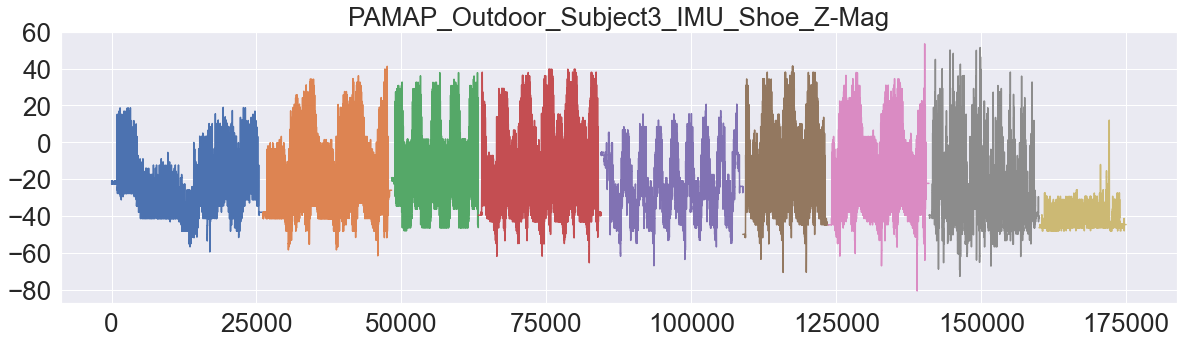

In [10]:
selection = 8
name, cps, ts = df.iloc[selection, :].tolist()

plot_ts(
    name,
    ts,
    cps,
    show=True
)

Finally, let's create and save the TS dataset.

In [14]:
DATASET_PATH = "../../datasets/PAMAP/"

In [15]:
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)

In [64]:
# print(f"{name},100,{','.join(dp.map(str, new_cps))}")
# np.savetxt(f"../datasets/VLTS/{name}.txt", new_ts)

PAMAP_Outdoor_Subject3_IMU_Shoe_Z-Mag,100,26159,48296,63255,84462,108877,123637,140979,159971
PAMAP_Outdoor_Subject3_IMU_Shoe_Z-Mag,0,174989


In [16]:
desc = []
data = dict()
window_size = 100

for subjects, mode in meta:
    for subject in subjects:
        df = load_pamap_ts(subject, mode)
        
        for _, (name, cps, ts) in df.iterrows():
            desc.append(f"{name},{window_size},{','.join(dp.map(str, cps))}")
            data[name] = ts
            
np.savetxt(f"{DATASET_PATH}desc.txt", desc, fmt="%s")
np.savez(f"{DATASET_PATH}data.npz", **data)